### Estimation of payment plan days (looping through groupby object)

In [31]:
# refine number of days to match plans
def match_plan(df_in):
    # set to 30-days when delta days is between 28 and 32
    crit_30 = (df_in.delta_days >= 28) & (df_in.delta_days <= 32)
    df_in.loc[crit_30, 'delta_days'] = 30
    
    return df_in

In [32]:
def compute_plan_days(df_current):
    # offset date by one row (must use .values otherwise it will attempt to align data)
    # df_current.iloc[1:, 10] = df_current.iloc[:-1, 7].values
    df_current.loc[df_current.index[1:],'prior_expiration'] =\
                                df_current.loc[df_current.index[:-1],'membership_expire_date'].values

    # compute delta days when transaction date is anterior to prior expiration date and no active cancellation
    crit_mem = (df_current.transaction_date <= df_current.prior_expiration) & (df_current.is_cancel == False)
    df_current.loc[crit_mem,'delta_days'] = (df_current.loc[crit_mem, 'membership_expire_date'] -\
                                df_current.loc[crit_mem, 'prior_expiration']).astype('timedelta64[D]')

    # take care of one time occurrence when transaction date and expiration date do not overlap
    crit_unq = (df_current.delta_days.isnull()) & (df_current.is_cancel == False)
    df_current.loc[crit_unq, 'delta_days'] = np.floor((df_current.loc[crit_unq, 'membership_expire_date'] - \
                                            df_current.loc[crit_unq, 'transaction_date'])/pd.Timedelta('1 day'))

    # fillna() with forward fill for active cancellation (all remaining NaN except if first record in current df)
    df_current.delta_days = df_current.delta_days.fillna(method='ffill')

    return df_current

In [157]:
# 2,363,626 users
# df_group.groups.keys()
import time

In [54]:
df_group = df_transac.groupby('msno', sort=False)

In [57]:
# Take 345 second for 100 => 3.45s per group! that's 92 days of running time! not acceptable
# Not dropping any records and keeping track of them instead, 28.5s for 100 => 0.285s per group, that's 7 days
# In addition not making changes and keeping track of them, 11s for 100 => 0.11s per group, that's 3 days
#(1.7 days if msno is categorical)
# get start time of timer for processing time
start_time = time.time()
counter = 0
record2remove = []

for user_name, user_df in df_group:
    # get transactions from user
    df_current = compute_plan_days(user_df.sort_values(['transaction_date', 'membership_expire_date']))
    
    # remove any remaining NaN and negative delta days
    crit_rm = (df_current.delta_days.isnull())  | ( df_current.delta_days <= 0 )
    
    # remove them in the master dataframe
#     df_transac.drop(df_current[crit_rm].index, inplace = True)
    record2remove.extend(df_current[crit_rm].index)
    # have to do it after I used it for df_transac
    df_current = df_current[~crit_rm].copy()

    # adjust days to match monthly plan when applicable
    df_current = match_plan(df_current)

    # replace 0-days payment plan by delta days
    crit_rpl = df_current.payment_plan_days == 0
    # df_current.loc[crit_rpl, 'payment_plan_days'] = df_current.loc[crit_rpl, 'delta_days'].astype('int64')
    # do it again on the master dataframe...
    index2change = df_current[crit_rpl].index
#     df_transac.loc[index2change, 'payment_plan_days'] = df_current.loc[crit_rpl, 'delta_days'].astype('int64')
    
    counter += 1
    if counter > 100: break

print("--- %s seconds ellapsed in for loop---" % (time.time() - start_time))

--- 6.549419403076172 seconds ellapsed in for loop---


### Estimation for automatic renewal 

In [61]:
c2 = (~df_transac.index.isin(first_trans)) & (df_transac.is_auto_renew == True) & (df_transac.is_cancel == False)

In [63]:
# number of events where a user signed up after its membership expired and activated automatic renewal
df_transac.loc[c2, 'is_auto_renew'].sum() - df_transac.loc[crit_mem, 'is_auto_renew'].sum() 

2436265

In [66]:
# events where users started their membership again with auto renew on
df_transac.loc[c2 & ~crit_mem, :].head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,prior_expiration,delta_days
3593643,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39,30,149,149,True,2016-01-31,2016-03-19,False,2016-01-19,NaN
16269015,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39,30,149,149,True,2016-07-31,2016-09-19,False,2016-03-19,NaN
15916005,++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=,39,30,149,149,True,2016-01-31,2016-03-23,False,2016-01-23,NaN
9492469,++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=,39,30,149,149,True,2016-07-31,2016-09-23,False,2016-03-23,NaN
19468938,++/ZHqwUNa7U21Qz+zqteiXlZapxey86l6eEorrak/g=,14,0,0,149,True,2015-06-30,2015-07-31,False,2015-04-30,NaN


### Unique transaction, missing payment plan days replacement strategy
From unique transaction without missing payment plan days values, get the most popular actual amount paid.
When an amount is linked to multiple plan days then pick the most significant plan days in terms of count in data.

In [ ]:
# discard active cancellation, unique transaction with missing payment days
crit_unq_cancel = (df_transac.msno.isin(users_unq_trans)) & (df_transac.payment_plan_days == 0) & (df_transac.is_cancel == True)
df_transac = df_transac.loc[ ~crit_unq_cancel ,:]

In [329]:
crit_fill_plan = (df_transac.msno.isin(users_unq_trans)) & (df_transac.payment_plan_days != 0) & (df_transac.is_cancel == False)

df_plan_grouped = df_transac.loc[ crit_fill_plan, ['payment_plan_days', 'actual_amount_paid']].groupby('payment_plan_days')

# most common actual ammount paid and its associated count
df_mcommon = df_plan_grouped.agg([lambda x: x.mode(), 'size'] )

# remove top level column
df_mcommon.columns = df_mcommon.columns.droplevel(0)

# rename columns
df_mcommon.columns = ['top_actual_amount', 'freq_count']

# group by top actual amount paid and keep top payment plan days
s_mcommon = df_mcommon.groupby('top_actual_amount')['freq_count'].nlargest(n=1)

# move second level index (payment plan days) to a column
s_mcommon = s_mcommon.reset_index(level = 1)

# drop frequency count column (not needed anymore)
s_mcommon.drop('freq_count', axis = 1, inplace = True)

In [317]:
# df_plan_grouped.nth(0)
# df_plan_grouped.ngroup()
# df_plan_grouped.describe()
# len(df_plan_grouped)

In [308]:
# _ , axunq = plt.subplots(len(df_plan_grouped),1, figsize=(8, 80))

# for ind, (plan_name, plan_df) in enumerate(df_plan_grouped):
#     pl_x = plan_df['actual_amount_paid'].sort_values().values
#     pl_y = np.arange(1, len(pl_x)+1) / len(pl_x)
#     axunq[ind].plot(pl_x, pl_y, '.')
#     axunq[ind].set_ylabel('{:.2f}'.format(plan_name))

### Missing payment plan days replacement strategy (based on actual amount paid)

Rely only on actual amount paid again but uses probabilities instead of raw counts.

In [36]:
# select transactions with no missing payment plan days and no active cancellation
crit_fill_plan = (df_transac.payment_plan_days != 0) & (df_transac.is_cancel == False)

In [37]:
# group by payment plan days
df_plan_grouped = df_transac[ crit_fill_plan ].groupby('payment_plan_days')

In [38]:
# count number of actual amount for each payment plan days
s_mcommon = df_plan_grouped.actual_amount_paid.value_counts()

In [39]:
# count total number of actual amount for each payment plan days and broadcast values to actual amount groups
s_1, s_2 = s_mcommon.align(s_mcommon.sum(level = 0), axis = 0, level = 0)

In [40]:
# concatenate in a single multi-index dataframe
df_mcommon =  pd.concat([s_1, s_2], axis = 1)

# rename columns
df_mcommon.columns = ['amount_count', 'total_amount_count']

In [41]:
df_mcommon['amount_proba'] = df_mcommon.amount_count / df_mcommon.total_amount_count * 100

In [42]:
df_mcommon

amount_count  total_amount_count  \
payment_plan_days actual_amount_paid                                     
1                 0                           3787                3787   
2                 10                            67                  67   
3                 15                            48                  56   
                  0                              8                  56   
7                 0                         552601              559866   
                  35                          7265              559866   
10                0                          33667               34695   
                  50                          1028               34695   
14                0                           5459                5704   
                  70                           245                5704   
15                0                             21                  21   
21                0                            516                 860   
                  105                          344                 860   
30                149                     10269335            17734538   
                  99                       4707996            17734538   
                  129                      1055814            17734538   
                  180                       647562            17734538   
                  150                       378093            17734538   
                  119                       305306            17734538   
                  0                         286712            17734538   
                  100                        74770            17734538   
                  120                         4112            17734538   
                  134                         3536            17734538   
                  124                          598            17734538   
                  131                          359            17734538   
                  143                          141            17734538   
                  127                           99            17734538   
                  1                             72            17734538   
                  210                           22            17734538   
                  30                             6            17734538   
...                                            ...                 ...   
180               800                           11               51087   
                  760                            4               51087   
                  600                            3               51087   
195               894                       108129              109258   
                  0                           1127              109258   
                  849                            1              109258   
                  890                            1              109258   
200               930                         5061                5815   
                  1000                         748                5815   
                  0                              4                5815   
                  894                            2                5815   
230               1150                         102                 102   
240               0                            825                 825   
270               894                          183                 183   
360               1200                        5437                5437   
365               1788                         222                 310   
                  0                             73                 310   
                  1520                          13                 310   
                  1825                           2                 310   
395               1599                        9696               10759   
                  0                           1063               10759   
400               1599                    

In [43]:
# only keep proba higher than a threshold (i.e. 95%)
df_mcommon_solid = df_mcommon[df_mcommon.amount_proba >= 95].reset_index(level = 1)
df_mcommon_solid

,actual_amount_paid,amount_count,total_amount_count,amount_proba
payment_plan_days,,,,
1,0,3787,3787,100.000000
2,10,67,67,100.000000
7,0,552601,559866,98.702368
10,0,33667,34695,97.037037
14,0,5459,5704,95.704769
15,0,21,21,100.000000
31,149,708803,723385,97.984199
35,149,817,817,100.000000
45,180,1082,1082,100.000000


In [44]:
# use z-score instead of nlargest
s_plan_rpl = df_mcommon_solid.groupby('actual_amount_paid').total_amount_count.nlargest(1)
s_plan_rpl = s_plan_rpl.reset_index(level = 1)
s_plan_rpl.drop('total_amount_count', axis = 1, inplace = True)

In [45]:
# don't replace when actual amount is zero
s_plan_rpl = s_plan_rpl.iloc[1:]

In [46]:
s_plan_rpl

,payment_plan_days
actual_amount_paid,
10,2
45,95
149,31
180,45
298,66
350,70
400,80
447,99
480,100


### Missing payment plan days replacement via machine learning
Features are payment ID, actual amount, auto renew, cancel and transaction-expiration delta days

### Using transaction-expiration date for users who renew on their own agenda

In [33]:
crit_1 = (df_transac.payment_plan_days != 0) & (df_transac.is_auto_renew == False) & (df_transac.is_cancel == False)

In [35]:
df = df_transac.loc[crit_1, ['payment_plan_days', 'membership_expire_date', 'transaction_date']].copy()

In [36]:
df['delta_days'] = (df[ 'membership_expire_date'] - df['transaction_date']).astype('timedelta64[D]')

In [39]:
time_diff = np.abs(df['delta_days'] - df['payment_plan_days'])

<IPython.core.display.Javascript object>


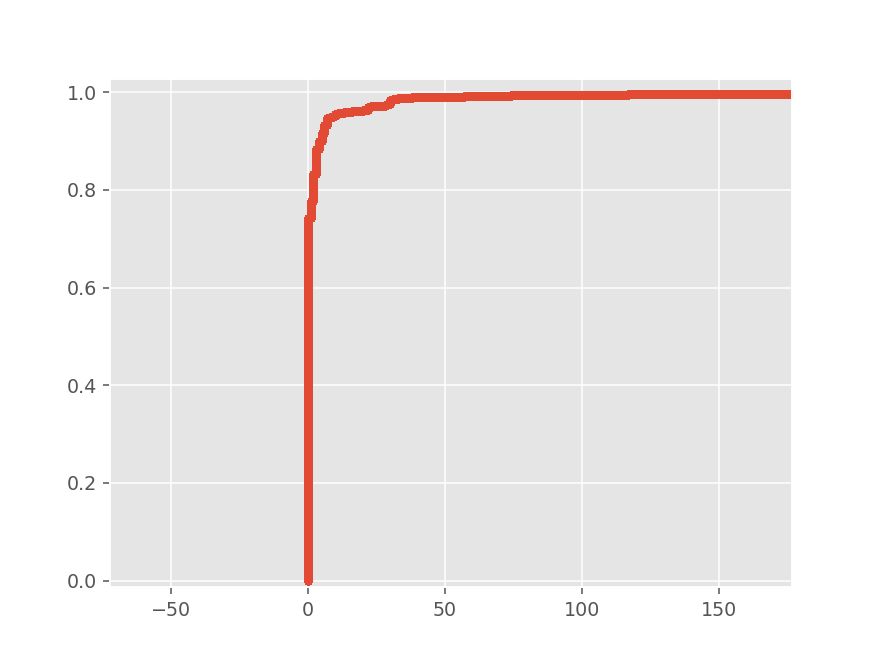

In [40]:
_ , axunq = plt.subplots()
pl_x = time_diff.sort_values().values
pl_y = np.arange(1, len(pl_x)+1) / len(pl_x)
axunq.plot(pl_x, pl_y, '.')

<IPython.core.display.Javascript object>


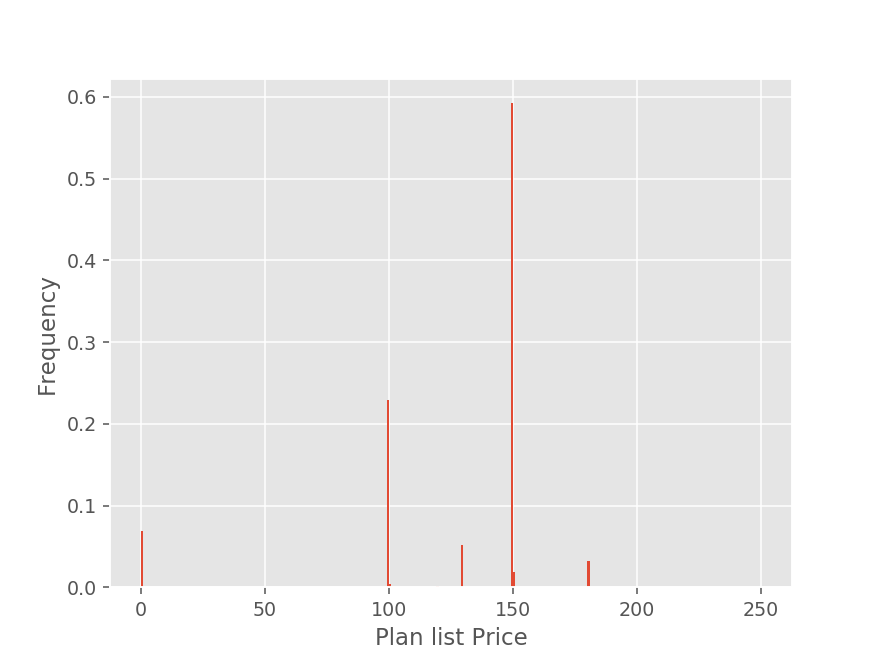

In [61]:
_ , axListPrice = plt.subplots()
_ = df_transac.plan_list_price.plot(kind = 'hist', \
                                bins = 250, range = (0,250), density = True,\
                                ax = axListPrice)
_ = axListPrice.set_xlabel('Plan list Price')